In [41]:
import numpy as np
import random
import time
import math
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint, Point, LineString
from shapely.ops import cascaded_union

In [2]:
random.seed(0)

In [290]:
curtime = time.time()
points = [[2.5, 4.5], [11.5, 16.5], [2.5, 2.5], [1.5, 10.5], [2.5, 7.5], [12.5, 9.5], [4.5, 7.5], [15.5, 2.5], [2.5, 11.5], [13.5, 3.5], [2.5, 4.5], [11.5, 16.5], [2.5, 2.5], [1.5, 10.5], [2.5, 7.5], [12.5, 9.5], [4.5, 7.5], [15.5, 2.5], [2.5, 11.5], [13.5, 3.5]]
a = [[(i-point[0])**2 + (j-point[1])**2 for point in points] for i in range(50) for j in range(50)]
temp_index = np.zeros(len(points), dtype=int)
temp = [int(x) for x in list('{0:0b}'.format(816))]
temp_index[-len(temp):] = temp
temp = np.array(a)[:,np.array(temp_index).astype(bool)]
np.array(a).shape, temp.shape

((2500, 20), (2500, 4))

In [3]:
def display_board(board, board_length, board_width):

    mapping = {
        0: '*',
        1: 'G',
        2: 'B',
        3: 'g',
        4: 'b'
    }

    for i in range(board_length):
        for j in range(board_width):
            index = i * board_length + j
            print(mapping.get(board[index], '?'), end=' ')
        print()

In [71]:
class Player:
    def __init__(self, board_length, board_width, num_pegs, num_rubberbands, player_color):
        self.name = "Greg" if player_color == 1 else "Bobby"
        self.board_length = board_length
        self.board_width = board_width
        self.point = 0
        self.board = []
        self.num_pegs = num_pegs
        self.num_rubberbands = num_rubberbands
        self.player_color = player_color #1: G, first player -- 2: B, second player.
        self.peg_coordinates = []
        self.rubberband_coordinates = []

        self.polygon_length_limit = 2*self.num_rubberbands + 1
        self.depth_limit = 1
        self.enemy_pegs = []
        self.polygon_candidates = []  # list of tuples (score, polygon(binary representation of indices), polygon(array representation))
        self.enemy_polygon_candidates = []

        self.rubberbands_sequence = []
        self.rubberbands_sequence_index = 0

    def find_enemy_pegs(self):
        for i in range(len(self.board)):
            if self.board[i] == 3 - self.player_color and i not in self.enemy_pegs:
                self.enemy_pegs.append(i)

    def find_polygon(self, pegs, opponent_pegs, polygon_candidates):
        # assume new_peg is the final peg in the list
        # print(pegs, opponent_pegs, polygon_candidates)
        new_polygon_candidates = [1]
        for _, polygon, _ in polygon_candidates:
            new_polygon_candidates.append((polygon << 1))
            new_polygon_candidates.append((polygon << 1) + 1)
        
        for i in range(len(new_polygon_candidates)-1,-1,-1):
            polygon = new_polygon_candidates[i]
            temp_index = np.zeros(len(pegs), dtype=int)
            temp = [int(x) for x in list('{0:0b}'.format(polygon))]
            # print(temp_index, temp)
            temp_index[-len(temp):] = temp
            temp_pegs = np.array(pegs)[np.array(temp_index).astype(bool)]

            temp_points, illegal_move, _ = self.rubberband_score((self.board_length, self.board_width), temp_pegs, [], opponent_pegs)

            if illegal_move:
                new_polygon_candidates.pop(i)
            else:
                new_polygon_candidates[i] = (temp_points, polygon, temp_pegs)

        new_polygon_candidates.sort(key=lambda x: x[0], reverse=True)
        new_polygon_candidates = new_polygon_candidates[:self.polygon_length_limit]
        
        return new_polygon_candidates

    def evaluate(self, pegs, polygon_candidates, enemy_pegs, enemy_polygon_candidates, new_peg=None):
        # evaluate with new_peg as optional argument
        # return my_score, enemy_score, my_rubberbands

        temp_polygon_candidates = polygon_candidates.copy()
        temp_enemy_polygon_candidates = enemy_polygon_candidates.copy()
        temp_pegs = pegs.copy()
        temp_enemy_pegs = enemy_pegs.copy()

        my_score, enemy_score = 0, 0
        my_rubberbands = []
        my_rubberband_coordinates, enemy_rubberband_coordinates = [],[]

        if new_peg is not None:
            temp_pegs.append(new_peg)
        
            temp_polygon_candidates = self.find_polygon(temp_pegs, temp_enemy_pegs, temp_polygon_candidates)
            temp_enemy_polygon_candidates = self.find_polygon(temp_enemy_pegs, temp_pegs, temp_enemy_polygon_candidates)
        
        for _ in range(min(self.num_rubberbands, len(temp_polygon_candidates))):
            max_round_score = -1
            max_rubberband = []
            max_index = -1
            max_temp_rubberband = []
            for i, (_, _, rubberband) in enumerate(temp_polygon_candidates):
                temp_points, illegal_move, temp_rubberband = self.rubberband_score((self.board_length, self.board_width), rubberband, my_rubberband_coordinates, temp_enemy_pegs)
                if not illegal_move:
                    if temp_points > max_round_score:
                        max_round_score = temp_points
                        max_rubberband = rubberband.copy()
                        max_index = i
                        max_temp_rubberband = temp_rubberband.copy()
            my_score += max_round_score
            my_rubberbands.append(max_rubberband)
            temp_polygon_candidates.pop(max_index)
            for peg in max_temp_rubberband:
                my_rubberband_coordinates.append(peg)

        for _ in range(min(self.num_rubberbands, len(temp_enemy_polygon_candidates))):
            max_round_score = -1
            max_rubberband = []
            max_index = -1
            max_temp_rubberband = []
            for i, (_, _, rubberband) in enumerate(temp_enemy_polygon_candidates):
                temp_points, illegal_move, temp_rubberband = self.rubberband_score((self.board_length, self.board_width), rubberband, enemy_rubberband_coordinates, temp_pegs)
                if not illegal_move:
                    if temp_points > max_round_score:
                        max_round_score = temp_points
                        max_rubberband = rubberband.copy()
                        max_index = i
                        max_temp_rubberband = temp_rubberband.copy()
            enemy_score += max_round_score
            temp_enemy_polygon_candidates.pop(max_index)
            for peg in max_temp_rubberband:
                enemy_rubberband_coordinates.append(peg)
        return my_score, enemy_score, my_rubberbands

    def pegs_to_points(self, pegs):
        points = []
        for i in range(len(pegs)):
            x1 = (int(pegs[i]%self.board_length) + 0.5) 
            y1 = (int(pegs[i]/self.board_length) + 0.5)
            points.append([x1, y1])
        return points

    def candidate_points(self, pegs, enemy_pegs, polygon_candidates, enemy_polygon_candidates):
        if len(pegs) == 0:
            return [i for i in [0, self.board_width-1, (self.board_length-1)*self.board_width, self.board_length*self.board_width-1] if i not in enemy_pegs]
        points = self.pegs_to_points(pegs)
        dist_from_pegs = np.array([[(i-point[0])**2 + (j-point[1])**2 for point in points] for i in range(self.board_length) for j in range(self.board_width)])
        
        # furthest points
        ans = []
        for _, polygon_index, _ in polygon_candidates:
            temp_index = np.zeros(len(pegs), dtype=int)
            temp = [int(x) for x in list('{0:0b}'.format(polygon_index))]
            temp_index[-len(temp):] = temp
            temp_dist = dist_from_pegs[:,np.array(temp_index).astype(bool)]
            temp_dist_sum = np.sum(temp_dist, axis=1)
            max_index = -1
            while max_index in enemy_pegs or max_index in pegs or max_index in ans or max_index == -1:
                max_index = np.argmax(temp_dist_sum)
                temp_dist_sum[max_index] = 0
            ans.append(max_index)
            if len(ans) >= 2:
                break

        # block enemy pegs
        block_indices = []
        enemy_polygons = []
        for _, _, polygon in enemy_polygon_candidates:
            if len(polygon) > 2: 
                enemy_polygons.append(Polygon(self.pegs_to_points(polygon)))
            elif len(polygon) == 2:
                enemy_polygons.append(LineString(self.pegs_to_points(polygon)))
            else:
                enemy_polygons.append(Point(self.pegs_to_points(polygon)))
        pegs_in_enemy_polygon = np.array([[1 if Point(i,j).within(polygon) else 0 for polygon in enemy_polygons] for i in range(self.board_length) for j in range(self.board_width)])
        enemy_polygon_scores = np.array([score for score, _, _ in enemy_polygon_candidates])
        pegs_block_score = pegs_in_enemy_polygon @ enemy_polygon_scores
        block_index = -1
        while len(block_indices) < 2:
            block_index = np.argmax(pegs_block_score)
            if block_index in enemy_pegs or block_index in pegs or block_index in ans or block_index == -1:
                pegs_block_score[block_index] = 0
            else:
                block_indices.append(block_index)
        for i in block_indices:
            ans.append(i)
        return ans

    def monte_carlo(self, pegs, polygon_candidates, enemy_pegs, enemy_polygon_candidates):
        temp_polygon_candidates = polygon_candidates.copy()
        temp_enemy_polygon_candidates = enemy_polygon_candidates.copy()
        temp_pegs = pegs.copy()
        temp_enemy_pegs = enemy_pegs.copy()

        candidates = self.candidate_points(temp_pegs, temp_enemy_pegs, temp_polygon_candidates, temp_enemy_polygon_candidates)
        print(candidates, temp_pegs, temp_enemy_pegs)
        value = np.zeros(len(candidates))
        count = np.zeros(len(candidates))
        cur_time = time.time()
        max_round_time = 0
        while time.time() - cur_time < 110/self.num_pegs - max_round_time:
            round_time = time.time()
            i = np.random.randint(len(candidates))
            temp_temp_pegs = temp_pegs.copy()
            temp_temp_enemy_pegs = temp_enemy_pegs.copy()
            temp_temp_pegs.append(candidates[i])
            temp_temp_polygon_candidates = self.find_polygon(temp_temp_pegs, temp_temp_enemy_pegs, temp_polygon_candidates)
            temp_temp_enemy_polygon_candidates = temp_enemy_polygon_candidates.copy()
            enemy_turn = True
            while len(temp_temp_pegs) != self.num_pegs or len(temp_temp_enemy_pegs) != self.num_pegs:
                if enemy_turn:
                    enemy_candidates = self.candidate_points(temp_temp_enemy_pegs, temp_temp_pegs, temp_temp_enemy_polygon_candidates, temp_temp_polygon_candidates)
                    # print(enemy_turn, temp_temp_enemy_pegs, enemy_candidates, temp_temp_enemy_polygon_candidates, temp_temp_pegs)
                    move = np.random.choice(enemy_candidates)
                    temp_temp_enemy_pegs.append(move)
                    temp_temp_enemy_polygon_candidates = self.find_polygon(temp_temp_enemy_pegs, temp_temp_pegs, temp_temp_enemy_polygon_candidates)
                    enemy_turn = False
                else:
                    my_candidates = self.candidate_points(temp_temp_pegs, temp_temp_enemy_pegs, temp_temp_polygon_candidates, temp_temp_enemy_polygon_candidates)
                    # print(enemy_turn, temp_temp_pegs, my_candidates, temp_temp_polygon_candidates, temp_temp_enemy_pegs)
                    while True:
                        move = np.random.choice(my_candidates)
                        if move not in temp_temp_enemy_pegs:
                            break
                    temp_temp_pegs.append(move)
                    temp_temp_polygon_candidates = self.find_polygon(temp_temp_pegs, temp_temp_enemy_pegs, temp_temp_polygon_candidates)
                    enemy_turn = True

            score, _, _ = self.evaluate(temp_pegs, temp_polygon_candidates, temp_enemy_pegs, temp_enemy_polygon_candidates)
            value[i] += score
            count[i] += 1
            max_round_time = max(max_round_time, time.time() - round_time)
            print("This round takes", time.time() - round_time, "seconds")
        ratio = np.zeros(len(candidates))
        for i in range(len(candidates)):
            if count[i] != 0:
                ratio[i] = value[i]/count[i]
        max_move = candidates[np.argmax(ratio)]
        print("Time taken:", time.time() - cur_time, "Iteration count:", np.sum(count))
        return max_move

    def place_pegs(self):
    # Fill this function to return your move to place a peg to the board
        # print(self.board, self.board_length, self.board_width, self.num_pegs, self.num_rubberbands, self.player_color, self.peg_coordinates)
        while True:
            position = random.randint(0, self.board_length * self.board_width - 1)
            if self.board[position] == 0:
                break
        # print(self.peg_coordinates, self.polygon_candidates, self.enemy_pegs, self.enemy_polygon_candidates)
        self.find_enemy_pegs()
        # print(self.peg_coordinates, self.polygon_candidates, self.enemy_pegs, self.enemy_polygon_candidates)
        if len(self.enemy_pegs) > 0:
            self.enemy_polygon_candidates = self.find_polygon(self.enemy_pegs, self.peg_coordinates, self.enemy_polygon_candidates)
        position = self.monte_carlo(self.peg_coordinates, self.polygon_candidates, self.enemy_pegs, self.enemy_polygon_candidates)
        print(position)
        self.peg_coordinates.append(position)
        self.polygon_candidates = self.find_polygon(self.peg_coordinates, self.enemy_pegs, self.polygon_candidates)
        return position

    def place_rubberbands(self):
        # Fill this function to return your move to place your rubberbands to the pegs
        if len(self.rubberbands_sequence) == 0:
            _, _, self.rubberbands_sequence = self.evaluate(self.peg_coordinates, self.polygon_candidates, self.enemy_pegs, self.enemy_polygon_candidates)
        # print(self.rubberbands_sequence, self.rubberbands_sequence_index)
        temp = self.rubberbands_sequence[self.rubberbands_sequence_index]
        print(self.name, temp)
        self.rubberbands_sequence_index += 1
        return temp

    def rubberband_score(self, board_size, rubberband_edges, rubberband_coordinates, enemy_pegs, print_flag = False):
        cross_move = False
        illegal_cross_move = False
        illegal_move = False
        temp_points = 0
        temp_rubberband = []
        ## Rubberband validity conditions
        proposed_rubberband = []
        if(len(rubberband_edges) == 1):
            proposed_rubberband = rubberband_edges
            temp_points += 1
        #If there is only a line of connection
        elif(len(rubberband_edges) == 2):
            proposed_rubberband, check_cross_move, bad_cross_move = self.rubberband_validity(rubberband_edges[0], rubberband_edges[1], board_size, enemy_pegs)
            if(check_cross_move):
                cross_move = True
            if(bad_cross_move):
                illegal_cross_move = True          
            temp_points = len(proposed_rubberband)
        elif(len(rubberband_edges) > 2):
            for i in range(len(rubberband_edges) - 1):
                temp_rubberband, check_cross_move, bad_cross_move = self.rubberband_validity(rubberband_edges[i], rubberband_edges[i+1], board_size, enemy_pegs)
                if(check_cross_move):
                    cross_move = True
                if(bad_cross_move):
                    illegal_cross_move = True
                for j in range(len(temp_rubberband)):
                    proposed_rubberband.append(temp_rubberband[j])
            temp_rubberband, check_cross_move, bad_cross_move = self.rubberband_validity(rubberband_edges[len(rubberband_edges)-1], rubberband_edges[0], board_size, enemy_pegs)
            if(check_cross_move):
                cross_move = True
            if(bad_cross_move):
                illegal_cross_move = True
            for j in range(len(temp_rubberband)):
                proposed_rubberband.append(temp_rubberband[j])

            proposed_rubberband = list(set(proposed_rubberband))

            convexity_check, pegs_inside = self.check_inside_rubberband(rubberband_edges, board_size[0])

            #print(f"Centers inside the polygon: {pegs_inside}")
            #print(f"Enemy peg coordinates: {players[other_player-1].peg_coordinates}")

            if(not convexity_check):
                illegal_move = True
                if print_flag:
                    print(f"The polygon is not convex! No rubberband placed by {self.name}")
            for i in range(len(pegs_inside)):
                if(pegs_inside[i] in enemy_pegs):
                    if print_flag:
                        print("There is an enemy peg inside the polygon!")
                    illegal_move = True
                else:
                    if(pegs_inside[i] not in proposed_rubberband):
                        proposed_rubberband.append(pegs_inside[i])
                        temp_points += 1                        


            proposed_rubberband = list(set(proposed_rubberband))
            temp_points = len(proposed_rubberband)
        
        #print(player.rubberband_coordinates)
        #print(proposed_rubberband)

        # for i in range(len(rubberband_edges)):
        #     if(rubberband_edges[i] not in self.peg_coordinates):
        #         illegal_move = True
        #         if print_flag:
        #             print("Given coordinates do not include your peg!")

        for i in range(len(proposed_rubberband)):
            if(proposed_rubberband[i] in enemy_pegs):
                if((cross_move and illegal_cross_move) or not cross_move):
                    if print_flag:
                        print("Rubberband cannot go from an enemy peg!")
                    illegal_move = True
                else:
                    temp_points -= 1
            elif(proposed_rubberband[i] in rubberband_coordinates):
                temp_points -= 1
            else:
                temp_rubberband.append(proposed_rubberband[i])
        
        return temp_points, illegal_move, temp_rubberband
    
    def rubberband_validity(self, peg1, peg2, board_size, enemy_pegs):
        check_cross_move = False
        illegal_cross_move = False
        start_peg = min(peg1, peg2)
        end_peg = max(peg1, peg2)

        x1 = int(start_peg%board_size[1])
        y1 = int(start_peg/board_size[0])+1
        x2 = int(end_peg%board_size[1])
        y2 = int(end_peg/board_size[0])+1

        positions = []  # List to store the positions the rubberband passes through

        vertical_diff = y1-y2
        horizontal_diff = x1-x2
        left_or_right = -1
        if(horizontal_diff >= 0):
            left_or_right *= 1
        else:
            left_or_right *= -1
        up_or_down = -1
        if(vertical_diff >= 0):
            up_or_down *= 1
        else:
            up_or_down *= -1

        if(horizontal_diff == 0):
            for i in range(abs(vertical_diff) + 1):
                positions.append(start_peg + up_or_down * board_size[0]*i)
        elif(vertical_diff == 0):
            for i in range(abs(horizontal_diff) + 1):
                positions.append(start_peg + left_or_right * i)
        # Diagonal move
        elif(abs(vertical_diff) == abs(horizontal_diff)):
            for i in range(abs(vertical_diff)+1):
                positions.append(start_peg + (up_or_down*i*board_size[0] + (left_or_right*(i))))
        #Cross move
        else:
            check_cross_move = True
            current_row = y1

            x1 += 0.5
            x2 += 0.5
            y1 -= 0.5
            y2 -= 0.5

            temp_x = x1
            temp_y = y1

            multiplier = 1
            if(vertical_diff * horizontal_diff < 0):
                multiplier = -1

            for i in range(abs(vertical_diff)):
                temp_increase = 0.5 + 1*i
                temp_y = y1 + temp_increase
                shift = multiplier * abs(horizontal_diff)*temp_increase/abs(vertical_diff)

                if(multiplier == 1):
                    start = math.floor(temp_x)
                    end = math.ceil(x1 + shift)
                else:
                    end = math.ceil(temp_x)
                    start = math.floor(x1 + shift)
                
                for j in range(end - start):
                    candidate_x = (start + 0.5) + j
                    candidate_y = current_row - 0.5
                    
                    positions.append(int((candidate_y-0.5)*board_size[0] + (candidate_x-0.5)))

                temp_x = x1 + shift
                current_row += 1

            temp_increase += 0.5
            temp_y = y2
            shift = multiplier * abs(horizontal_diff)*temp_increase/abs(vertical_diff)

            if(multiplier == 1):
                start = math.floor(temp_x)
                end = math.ceil(x1 + shift)
            else:
                end = math.ceil(temp_x)
                start = math.floor(x1 + shift)

            for j in range(end - start):
                candidate_x = (start + 0.5) + j
                candidate_y = current_row - 0.5
                
                positions.append(int((candidate_y-0.5)*board_size[0] + (candidate_x-0.5)))

            # Check if there is any enemy pegs in between for cross move
            for i in range(len(enemy_pegs)):
                cur_x = int(enemy_pegs[i]%board_size[1])
                cur_y = int(enemy_pegs[i]/board_size[0])+1
                # Line equation between pegs, check if it goes from any of the enemy pegs, illegal move.
                slope = vertical_diff/horizontal_diff
                if((cur_x - x1)*slope == (cur_y - y1)):
                    illegal_move = True

        return positions, check_cross_move, illegal_cross_move
    
    # Expand the polygon slightly to account for grid center intersections
    def expand_polygon(self, polygon_points, expansion_factor=0.001):
        if len(polygon_points) < 3:
            return polygon_points
        polygon = Polygon(polygon_points)
        expanded_polygon = polygon.buffer(expansion_factor)
        return list(expanded_polygon.exterior.coords)

    # Check if the polygon is convex
    def is_convex(self, polygon_points):
        if len(polygon_points) < 3:
            return True
        polygon = Polygon(polygon_points)
        convex_hull = polygon.convex_hull
        return polygon.equals(convex_hull)

    def sort_clockwise(self, pegs, board_size):
        pegs = np.array(pegs)
        points = self.pegs_to_points(pegs)
        center = MultiPoint(points).centroid.coords[0]
        key = [math.atan2(points[i][1] - center[1], points[i][0] - center[0]) for i in range(len(points))]
        return pegs[np.argsort(key)]

    def check_inside_rubberband(self, proposed_rubberband, board_size):
        proposed_rubberband = self.sort_clockwise(proposed_rubberband, board_size)
        points = self.pegs_to_points(proposed_rubberband)
        points.append(points[0])

        # Expand the polygon
        expanded_points = self.expand_polygon(points)

        # Check convexity
        if self.is_convex(expanded_points):
            convex_check = True
        else:
            convex_check = False

        grid_centers = [[0.5 + x, 0.5 + y] for y in range(board_size) for x in range(board_size)]
        # Create a Path object from the expanded polygon points
        path = mpath.Path(expanded_points)

        # Initialize a list to store the grid centers inside the polygon
        grid_centers_inside_polygon = []
        center_locations_inside_polygon = []

        # Check each grid center if it's inside the polygon
        for center in grid_centers:
            if path.contains_point(center):
                #if center not in points:
                grid_centers_inside_polygon.append(center)  
                center_locations_inside_polygon.append(int((center[1]*(-1) + board_size + 0.5 - 1)*(board_size) + (center[0] - 0.5))) 
        
        return convex_check, center_locations_inside_polygon

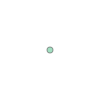

In [45]:
points = [[6.5, 6.5]]
Point(points)

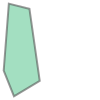

In [11]:
points = [[6.5, 6.5], [8.5, 1.5], [13.5, 4.5], [11.5, 18.5], [7.5, 19.5], [6.5, 6.5]]
Polygon(points)

In [72]:
# Define the game board size and initial state
n = 20
board_size = (n, n)
num_pegs = 10
num_rubberbands = 5
board = [0] * (board_size[0] * board_size[1])

# Create player objects and store them in a list
players = []
for i in range(2):
    players.append(Player(board_size[0], board_size[1], num_pegs, num_rubberbands, i+1))

######
# Peg placement phase 
for round in range(num_pegs):
    player_index = 1
    other_player_index = 2
    for player in players:
        # Send the current board with peg positions
        player.board = board.copy()
        position = player.place_pegs()

        # Update the board with the player's peg
        if(position >= 0 and position < board_size[0] * board_size[1]):
            if(board[position] == player_index):
                print(f"{player.name}, you have already placed a peg in this position!")
            elif(board[position] == other_player_index):
                print(f"{players[other_player_index-1].name} has a peg in this position! No peg is placed by {player.name}!")
            else:
                board[position] = player_index  # Alternates between Player 1 and Player 2
                print(f"{player.name} placed a peg at location {position}.")
        else:
            print(f"Coordinate out of range! No peg is placed by {player.name}!")
        player_index = 2
        other_player_index = 1


players[0].board = board.copy()
players[1].board = board.copy()

# Display the board
print("Initial board")
display_board(board, board_size[0], board_size[1])
print("-----")
print("Rubberband placement phase")
print("-----")
time.sleep(0.3)
#########
# Rubberband placement phase 
for round in range(num_rubberbands):
    player_index = 1
    other_player = 2
    for player in players:
        player.board = board.copy()
        rubberband_edges = player.place_rubberbands()

        temp_points, illegal_move, temp_rubberband = player.rubberband_score(board_size, rubberband_edges, player.rubberband_coordinates, players[other_player-1].peg_coordinates)
        
        if(illegal_move):
            temp_points = 0
        else:
            for i in range(len(temp_rubberband)):
                player.rubberband_coordinates.append(temp_rubberband[i])
                if((temp_rubberband[i] not in player.peg_coordinates) and temp_rubberband[i] not in players[other_player-1].peg_coordinates):
                    player.board[temp_rubberband[i]] = player_index+2  # Alternates between Player 1 and Player 2 --- #3: g, 4:b\
            player.point += temp_points

        # Switch players after sweeping through all rubberband squares.
        player_index = 2
        other_player = 1

    # print("-----")
    # display_board(players[0].board, board_size[0], board_size[1])
    # print("-----")
    # display_board(players[1].board, board_size[0], board_size[1])
    # print("-----")

# Calculate and announce the winner
print(f"{players[0].name}: {players[0].point} points, {players[1].name}: {players[1].point} points")
if(players[0].point > players[1].point):
    print(f"{players[0].name} wins!")
elif(players[0].point < players[1].point):
    print(f"{players[1].name} wins!")
else:
    print(f"It is a tie! {players[0].name} started first, {players[0].name} wins!")


[0, 19, 380, 399] [] []


KeyboardInterrupt: 

In [68]:
# check score for choice of pegs
cur_time = time.time()
max_index = np.zeros(len(green_pegs))
max_score = 0
for num in range(1,2**len(green_pegs)):
    temp_index = np.zeros(len(green_pegs))
    temp = [int(i) for i in list('{0:0b}'.format(num))]
    temp_index[-len(temp):] = temp

    temp_pegs = np.array(green_pegs)[np.array(temp_index).astype(bool)]
    
    temp_points, illegal_move, temp_rubberband = player[0].rubberband_score(board_size, temp_pegs, players[1].peg_coordinates)
    
    if temp_score > max_score:
        max_score = temp_score
        max_index = temp_index

print("takes", time.time() - cur_time, "seconds")
print(max_score, max_index, np.array(green_pegs)[np.array(max_index).astype(bool)])
    

NameError: name 'green_pegs' is not defined